In [43]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, decimate

In [ ]:
# ===== SESSION SELECTION =====
SESSION = "pup2"         # animal id
STIM = "brush_contra"  # stim type
# =============================


# Load table (prefer local override if present)
table_path = Path("data/sessions.csv")
sessions = pd.read_csv(table_path, sep=',')  # your CSV is comma-delimited


# Select row by session + stim
row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())]
if row.empty:
    raise ValueError(f"No row found for session={SESSION}, stim={STIM}")


row = row.iloc[0]


# Extract paths and metadata
phy_dir = Path(row['phy_dir'])
lfp_dir  = Path(row['lfp_dir'])
age = str(row['age']).strip()
notes = str(row['notes']).strip()


# Anatomy bands
S1_upper_um  = float(row['s1_upper_um'])
S1_lower_um  = float(row['s1_lower_um'])
VPL_upper_um = float(row['vpl_upper_um'])
VPL_lower_um = float(row['vpl_lower_um'])

# Insertion depth 
tip_dv_mm = float(row['tip_dv_mm'])

# Constants
BANK_SPAN_MM = 3.84  # Neuropixels 1.0 recording bank span

# Sanity check
if phy_dir is None or not phy_dir.exists():
    print(f"⚠️ Warning: phy_dir not found or empty for {SESSION}/{STIM}. Check paths or notes: '{notes}'")
if lfp_dir is None or not lfp_dir.exists():
    print(f"⚠️ Warning: lfp_dir not found or empty for {SESSION}/{STIM}. Check paths.")


print(f"Loaded: {SESSION} / {STIM} (age: {age})")
print(f"Notes: {notes}")
print(f"phy_dir: {phy_dir}")
print(f"lfp_dir:  {lfp_dir}")


Loaded: pup2 / brush_contra (age: p12)
Notes: Oop something
phy_dir: C:\Users\Ben\Desktop\Contra Brush\PUP2
lfp_dir:  E:\Neurpixels_Sally\pup2_SZMB_brush_contra_final_2024-12-19_16-47-20\Record Node 118\experiment1\recording1\continuous\Neuropix-PXI-117.ProbeA-LFP


In [45]:
# Parameters
t0, twin = 0.0, 30.0  # Time window in seconds
max_ch = None   # set to an int (e.g., 192) to cap plotted channels
bp_lo, bp_hi = 1, 300
gain = 10     # LFP gain per channel (adjust as needed)



Bank span: 3.84 mm
Top of bank: -1.32 mm DV
Tip (deepest site): 2.50 mm DV
Channels in brain: 251/383
Channels above surface: 132/383

✓ Saved: results\figures\pup2_brush_contra_allchannel_lfp_30.0s.png


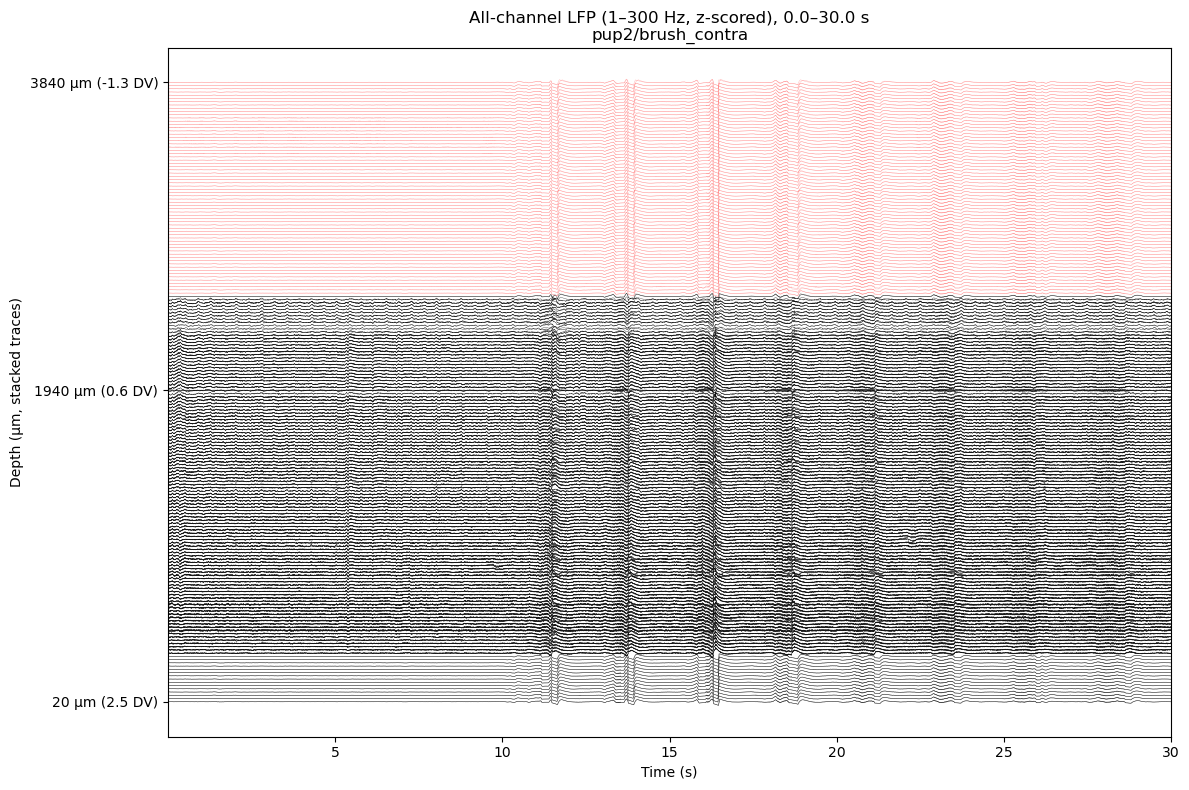

In [ ]:
# %%
# ---- Get spike zero for clock anchoring ----
spike_times = np.load(phy_dir/'spike_times.npy')
spike_fs = 30000.0
try:
    txt = (phy_dir/'params.py').read_text()
    for line in txt.splitlines():
        if 'sample_rate' in line and '=' in line:
            spike_fs = float(line.split('=')[-1]); break
except Exception:
    pass
spike_zero = float(spike_times.min()/spike_fs)


# ---- Load channel positions and compute DV coordinates ----
chan_pos = np.load(phy_dir/'channel_positions.npy')  # (n_channels, 2)
depths_um = chan_pos[:,1]  # relative depth along probe in µm

# Compute absolute DV per channel if tip_dv_mm is available
if tip_dv_mm is not None:
    # Tip is at the LOWEST depth value (e.g., 20 µm), not the highest
    min_depth_um = np.min(depths_um)
    
    # Convert each channel's relative position to absolute DV
    # Tip is at min_depth_um, so:
    # DV = tip_dv_mm - (depth_um - min_depth_um) / 1000
    # This means channels higher up the shank (larger depth_um) have SMALLER DV
    dv_channels_mm = tip_dv_mm - (depths_um - min_depth_um) / 1000.0
    
    # Flag channels inside brain (DV >= 0)
    in_brain = dv_channels_mm >= 0.0
    
    # Compute bank range
    max_depth_um = np.max(depths_um)
    actual_span_mm = (max_depth_um - min_depth_um) / 1000.0
    top_bank_dv_mm = tip_dv_mm - actual_span_mm
    
    print(f"\nBank span: {BANK_SPAN_MM:.2f} mm")
    print(f"Top of bank: {top_bank_dv_mm:.2f} mm DV")
    print(f"Tip (deepest site): {tip_dv_mm:.2f} mm DV")
    print(f"Channels in brain: {np.sum(in_brain)}/{len(in_brain)}")
    print(f"Channels above surface: {np.sum(~in_brain)}/{len(in_brain)}")
else:
    dv_channels_mm = None
    in_brain = np.ones(len(depths_um), dtype=bool)  # assume all in brain if no tip info


# ---- Load LFP data directly ----
# Find the LFP continuous.dat file
lfp_file = lfp_dir / 'continuous.dat'
if not lfp_file.exists():
    raise FileNotFoundError(f"LFP file not found: {lfp_file}")


# LFP parameters
fs_lfp = 2500.0     # LFP sampling rate (Hz)
dtype_lfp = np.int16
n_channels = 384    # Neuropixels v1.0


# Calculate time window
if twin is None:
    # Load full file
    total_bytes = lfp_file.stat().st_size
    total_samples = total_bytes // (n_channels * 2)  # int16 = 2 bytes
    samples_start = int(t0 * fs_lfp)
    n_samples = total_samples - samples_start
else:
    t1 = t0 + twin
    samples_start = int(t0 * fs_lfp)
    n_samples = int(twin * fs_lfp)


# Load LFP data via memmap
byte_offset = samples_start * n_channels * np.dtype(dtype_lfp).itemsize
mm_lfp = np.memmap(lfp_file, dtype=dtype_lfp, mode='r', offset=byte_offset)
data_lfp = mm_lfp[:n_samples * n_channels]
lfp = data_lfp.reshape(-1, n_channels).astype('float32')  # shape: (time, channels)


# Create time vector aligned to spike clock
t_lfp = np.arange(lfp.shape[0]) / fs_lfp + t0
# Align to spike zero (LFP starts at same hardware clock as spikes)
t_lfp += spike_zero


# ---- Pick channels and ordering by depth ----
order = np.argsort(depths_um)  # shallow -> deep
if max_ch is not None:
    # subsample channels uniformly by depth if too many
    step = max(1, len(order)//max_ch)
    order = order[::step]


# Select channels in depth order
X = lfp[:, order]
t = t_lfp
depths_sel = depths_um[order]
in_brain_sel = in_brain[order] if dv_channels_mm is not None else np.ones(len(order), dtype=bool)
dv_sel = dv_channels_mm[order] if dv_channels_mm is not None else None


# ---- Display band-pass and z-score per channel ----
def bandpass(x, fs, lo=bp_lo, hi=bp_hi, order=3):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)


try:
    Xb = bandpass(X, fs_lfp, bp_lo, bp_hi, order=3)
except Exception:
    Xb = X


def zscore2D(M):
    m = np.median(M, axis=0, keepdims=True)
    s = np.std(M, axis=0, keepdims=True)
    s[s==0] = 1.0
    return (M - m) / s

Z = zscore2D(Xb)


# ---- Stack and plot: offset by depth (µm) to make a depth map ----
# normalize depth range to a neat spacing
dmin, dmax = float(np.nanmin(depths_sel)), float(np.nanmax(depths_sel))
depth_norm = (depths_sel - dmin) / max(1.0, (dmax - dmin))
offsets = depth_norm * 10000.0    # vertical span for all channels                   
Y = Z * gain + offsets  # stacked signals


# Plot with biological/non-biological highlighting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot biological channels in black, non-biological in red
for i in range(Y.shape[1]):
    color = 'black' if in_brain_sel[i] else 'red'
    alpha = 0.7 if in_brain_sel[i] else 0.3
    ax.plot(t, Y[:, i], color=color, linewidth=0.3, alpha=alpha)

ax.set_xlim(t[0], t[-1])

# Y-axis labels: show both relative µm and absolute DV (if available)
yticks_pos = [offsets[0], offsets[len(offsets)//2], offsets[-1]]
if dv_sel is not None:
    yticks_lab = [
        f"{int(depths_sel[0])} µm ({dv_sel[0]:.1f} DV)",
        f"{int(depths_sel[len(offsets)//2])} µm ({dv_sel[len(offsets)//2]:.1f} DV)",
        f"{int(depths_sel[-1])} µm ({dv_sel[-1]:.1f} DV)"
    ]
else:
    yticks_lab = [f"{int(depths_sel[0])} µm", f"{int(depths_sel[len(offsets)//2])} µm", f"{int(depths_sel[-1])} µm"]

ax.set_yticks(yticks_pos)
ax.set_yticklabels(yticks_lab)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Depth (µm, stacked traces)")

title_str = f"All-channel LFP ({bp_lo}–{bp_hi} Hz, z-scored), {t[0]:.1f}–{t[-1]:.1f} s"
if dv_channels_mm is not None:
    title_str += f"\n{SESSION}/{STIM}"
ax.set_title(title_str)
plt.tight_layout()


# ---- Save figure to results folder ----
out_dir = Path("results/figures")
out_dir.mkdir(parents=True, exist_ok=True)

# Build descriptive filename
filename = f"{SESSION}_{STIM}_allchannel_lfp_{t[-1]:.1f}s.png"
out_path = out_dir / filename

plt.savefig(out_path, dpi=200, bbox_inches="tight")
print(f"\n✓ Saved: {out_path}")

plt.show()